## Notebook for the 3 baseline models and their evaluations ##

In [60]:
import numpy as np
import pandas as pd
from typing import Optional
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import math
import matplotlib.pyplot as plt

In [61]:
class MeanBaseline:
    def __init__(self) -> None:
        self.mean = None

    def fit(self, dataframe: pd.DataFrame, window: Optional[int] = None) -> None:
        """
        Fit the MeanBaseline model to the input DataFrame.

        Args:
            dataframe (pd.DataFrame): The input DataFrame.
            window (int, optional): The size of the rolling window. If not provided, the window size is set to the
                                    number of rows in the DataFrame.

        Returns:
            None
        """
        if window is None:
            window = dataframe.shape[0]

        self.mean = dataframe.rolling(window).mean()

    def predict(self, length: int) -> pd.DataFrame:
        """
        Generate predictions using the MeanBaseline model.

        Args:
            length (int): The number of predictions to generate.

        Returns:
            pd.DataFrame: The predicted values.
        """
        array = np.ones(shape=(length, self.mean.shape[1]))
        result = array * np.array(self.mean.iloc[-1, :])
        result = pd.DataFrame(result)
        return result


In [62]:
def col_names(df):
    ''' this function renames the columns to make them easier to read 
      additionally set the date as index in our dataframe'''
    column_names = {'Photovoltaics [MWh] Original resolutions': 'Solar_generation_MWh',
                'Photovoltaics [MW] Calculated resolutions': 'Solar_installed_MW',
                'Total (grid load) [MWh] Original resolutions': 'Total_consumption_MWh',
                'Germany/Luxembourg [€/MWh] Calculated resolutions': 'DE_LU_price_per_MWh',}
    df.rename(columns=column_names, inplace=True)
    return df

In [63]:
def test_train_timeseries(df, target):
    ''' In the first part we select the train and test data.
    In the second per the columns we want to use for our predictions '''
    
    test = df[df.Date >= '2022-06-01']
    train = df[df.Date < '2022-06-01'] #alternatively use 2022-05-25

    # now we select the columns we want to use for our predictions

    test = test[target]
    train = train[target]
    return test, train



In [64]:
# split a univariate sequence into samller samples to feed into the LSTM
def split_sequence(input, n_steps, pred_size, target = []):
    ''' This function will split our timeseries into supervised timeseries snipets. 
    input = dataframe to be split
    n_steps = length of the X_variable 
    pred_size = length of the y_variable
    target
    target = list of targets to be split
    At the same time we will collect the corresponding timestamps in two additional arrays '''
    input_array = input[target]
    date_array = input['Date']

    x_index, y_index = list(), list()
    x, y = list(), list()
    for i in range(len(input_array)):
        end_ix = i + n_steps # find the end of this pattern
        if end_ix+pred_size > len(input)-1: # check if we are beyond the sequence
            break
        seq_x, seq_y = input_array[i:end_ix], input_array[end_ix: end_ix+pred_size]# gather input and output parts of the pattern
        ind_x, ind_y = date_array[i:end_ix], date_array[end_ix: end_ix+pred_size]# gather input and output Dates of the pattern
        x.append(seq_x)
        y.append(seq_y)
        x_index.append(ind_x)
        y_index.append(ind_y)

    
    return np.array(x), np.squeeze(np.array(y)), np.array(x_index), np.squeeze(np.array(y_index)) 

In [65]:
df = pd.read_pickle('../data/final_dataframe.pkl')
df = col_names(df)

In [66]:
df.columns

Index(['Date', 'Solar_generation_MWh', 'Solar_installed_MW',
       'Total_consumption_MWh', 'DE_LU_price_per_MWh', 'normalisation_factor',
       'Solar_generation_MWh_normalized'],
      dtype='object')

## Baseline model for Solar Generation

In [83]:
target = ['Date', 'Solar_generation_MWh_normalized']

test, train = test_train_timeseries(df, target)
test.to_pickle('../data/solar_test.pkl')
train.to_pickle('../data/solar_train.pkl')

In [84]:
# define input sequence
input = train
# choose a number of time steps
n_steps = 672
# prediction size 
pred_size= 96
# columns to use for prediction
target = ['Solar_generation_MWh_normalized']

# split into samples
X, y, X_train_index, Y_train_index = split_sequence(input, n_steps, pred_size, target)

In [85]:
X_test, y_test, X_test_index, Y_test_index = split_sequence(test , n_steps, pred_size, target)

In [86]:
def baseline_df(X_test, X_test_index, target):
    #X_trial_1 = scaler.inverse_transform(X_test.reshape(X_test.shape[0], X_test.shape[1]))
    x_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[1])[:1,:].T, columns=[target])
    X_index_df = pd.DataFrame(X_test_index[:1,:].T, columns=['Date'])
    X_index_df['Date'] = pd.to_datetime(X_index_df['Date'])
    baseline = pd.concat([X_index_df, x_test_df], axis = 1)
    return baseline


In [87]:
df_solar = baseline_df(X_test, X_test_index, target)

In [88]:
def baseline_predictions(df, target):
    baseline_model = MeanBaseline()
    baseline_model.fit(df[[target]], window=24*4)
    df_predictions = pd.DataFrame(baseline_model.predict(24*4))
    df_predictions.columns = ['predicted']
    df_new = pd.concat([df, df_predictions])
    while df_new.isnull().sum()[0] > 0:
        df_new['Date'] = df_new['Date'].fillna(df_new['Date'].shift() + pd.Timedelta(minutes=15))
    df_new.set_index('Date',inplace=True, drop=True)
    return df_new , df_predictions

In [89]:
df_new, df_predictions = baseline_predictions(df_solar, target)

In [90]:
df_plotting = df_new.tail(500)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


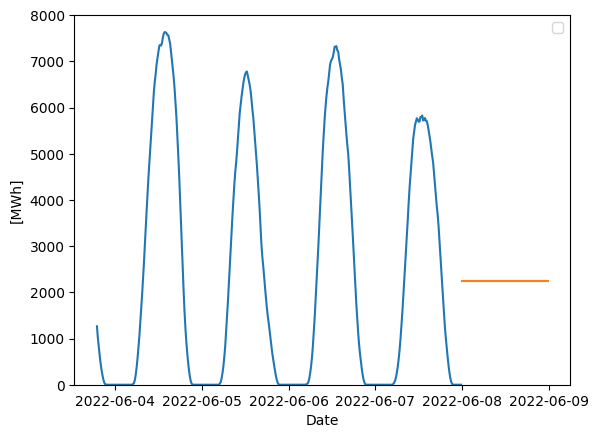

In [94]:
fig = plt.figure()
ax = plt.subplot()
plt.plot(df_plotting)
plt.ylim(0,8000)
plt.ylabel('[MWh]')
plt.xlabel('Date')
plt.legend()
plt.show()

In [76]:
def true_df(y_test, Y_test_index):
    y_test_df = pd.DataFrame(y_test[:1, : ].T, columns=['y_true'])
    y_df = pd.concat([pd.DataFrame(Y_test_index[:1,:].T , columns=['Date']), y_test_df], axis=1)
    return y_df

In [77]:
y_df = true_df(y_test, Y_test_index)

In [78]:
mse_baseline = mean_squared_error(y_df['y_true'], df_predictions['predicted'])
mape_baseline = mean_absolute_percentage_error(y_df['y_true'], df_predictions['predicted'])
r2_baseline = r2_score(y_df['y_true'], df_predictions['predicted'])

In [79]:
print(f'RMSE_baseline: {math.sqrt(mse_baseline)}\n MAPE_baseline: {mape_baseline}')
print(f'MSE_baseline: {mse_baseline}\n R2 score baseline: {r2_baseline}')

RMSE_baseline: 2818.193335024223
 MAPE_baseline: 2.8480606757368827e+18
MSE_baseline: 7942213.6735749515
 R2 score baseline: -0.015208479879987857


## Baseline for Consumption ##

In [80]:
df.columns

Index(['Date', 'Solar_generation_MWh', 'Solar_installed_MW',
       'Total_consumption_MWh', 'DE_LU_price_per_MWh', 'normalisation_factor',
       'Solar_generation_MWh_normalized'],
      dtype='object')

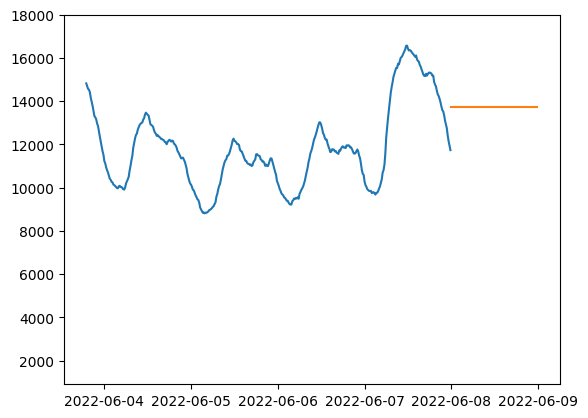

RMSE_baseline: 2009.4091732813697
 MAPE_baseline: 0.13690326697795152
MSE_baseline: 4037725.225667318
 R2 score baseline: -0.016019269849514517


In [81]:
target = ['Date', 'Total_consumption_MWh']

test, train = test_train_timeseries(df, target)
test.to_pickle('../data/consumption_test.pkl')
train.to_pickle('../data/consumption_train.pkl')
# define input sequence
input = train
# choose a number of time steps
n_steps = 672
# prediction size 
pred_size= 96
# columns to use for prediction
target = ['Total_consumption_MWh']

# split into samples
X, y, X_train_index, Y_train_index = split_sequence(input, n_steps, pred_size, target)

X_test, y_test, X_test_index, Y_test_index = split_sequence(test , n_steps, pred_size, target)

def baseline_df(X_test, X_test_index, target):
    #X_trial_1 = scaler.inverse_transform(X_test.reshape(X_test.shape[0], X_test.shape[1]))
    x_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[1])[:1,:].T, columns=[target])
    X_index_df = pd.DataFrame(X_test_index[:1,:].T, columns=['Date'])
    X_index_df['Date'] = pd.to_datetime(X_index_df['Date'])
    baseline = pd.concat([X_index_df, x_test_df], axis = 1)
    return baseline

df_consumption = baseline_df(X_test, X_test_index, target)

def baseline_predictions(df, target):
    baseline_model = MeanBaseline()
    baseline_model.fit(df[[target]], window=24*4)
    df_predictions = pd.DataFrame(baseline_model.predict(24*4))
    df_predictions.columns = ['predicted']
    df_new = pd.concat([df, df_predictions])
    while df_new.isnull().sum()[0] > 0:
        df_new['Date'] = df_new['Date'].fillna(df_new['Date'].shift() + pd.Timedelta(minutes=15))
    df_new.set_index('Date',inplace=True, drop=True)
    return df_new, df_predictions

df_new, df_predictions = baseline_predictions(df_consumption, target)

df_plotting = df_new.tail(500)


fig = plt.figure()
ax = plt.subplot()
plt.plot(df_plotting)
plt.ylim(900,18000)
plt.ylabel('[MWh]')
plt.xlabel('Date')
plt.show()


def true_df(y_test, Y_test_index):
    y_test_df = pd.DataFrame(y_test[:1, : ].T, columns=['y_true'])
    y_df = pd.concat([pd.DataFrame(Y_test_index[:1,:].T , columns=['Date']), y_test_df], axis=1)
    return y_df

y_df = true_df(y_test, Y_test_index)

mse_baseline = mean_squared_error(y_df['y_true'], df_predictions['predicted'])
mape_baseline = mean_absolute_percentage_error(y_df['y_true'], df_predictions['predicted'])
r2_baseline = r2_score(y_df['y_true'], df_predictions['predicted'])
print(f'RMSE_baseline: {math.sqrt(mse_baseline)}\n MAPE_baseline: {mape_baseline}')
print(f'MSE_baseline: {mse_baseline}\n R2 score baseline: {r2_baseline}')

## Baseline Price 

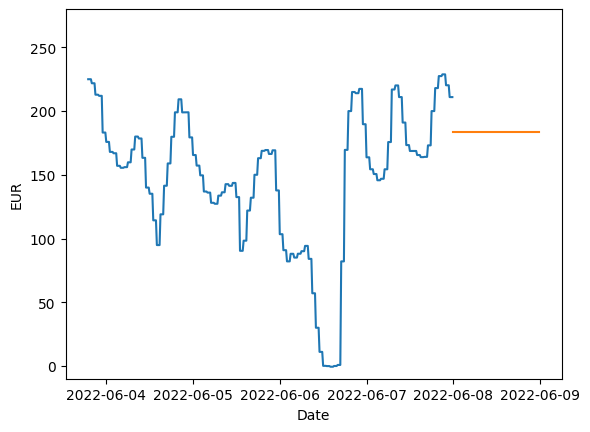

RMSE_baseline: 19.7799626446114
 MAPE_baseline: 0.08273496799790504
MSE_baseline: 391.2469222222223
 R2 score baseline: -0.11965728940530362


In [95]:
target = ['Date', 'DE_LU_price_per_MWh']

test, train = test_train_timeseries(df, target)
test.to_pickle('../data/consumption_test.pkl')
train.to_pickle('../data/consumption_train.pkl')
# define input sequence
input = train
# choose a number of time steps
n_steps = 672
# prediction size 
pred_size= 96
# columns to use for prediction
target = ['DE_LU_price_per_MWh']

# split into samples
X, y, X_train_index, Y_train_index = split_sequence(input, n_steps, pred_size, target)

X_test, y_test, X_test_index, Y_test_index = split_sequence(test , n_steps, pred_size, target)

def baseline_df(X_test, X_test_index, target):
    #X_trial_1 = scaler.inverse_transform(X_test.reshape(X_test.shape[0], X_test.shape[1]))
    x_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[1])[:1,:].T, columns=[target])
    X_index_df = pd.DataFrame(X_test_index[:1,:].T, columns=['Date'])
    X_index_df['Date'] = pd.to_datetime(X_index_df['Date'])
    baseline = pd.concat([X_index_df, x_test_df], axis = 1)
    return baseline

df_consumption = baseline_df(X_test, X_test_index, target)

def baseline_predictions(df, target):
    baseline_model = MeanBaseline()
    baseline_model.fit(df[[target]], window=24*4)
    df_predictions = pd.DataFrame(baseline_model.predict(24*4))
    df_predictions.columns = ['predicted']
    df_new = pd.concat([df, df_predictions])
    while df_new.isnull().sum()[0] > 0:
        df_new['Date'] = df_new['Date'].fillna(df_new['Date'].shift() + pd.Timedelta(minutes=15))
    df_new.set_index('Date',inplace=True, drop=True)
    return df_new, df_predictions

df_new, df_predictions = baseline_predictions(df_consumption, target)

df_plotting = df_new.tail(500)


fig = plt.figure()
ax = plt.subplot()
plt.plot(df_plotting)
plt.ylim(-10,280)
plt.ylabel('EUR')
plt.xlabel('Date')
plt.show()


def true_df(y_test, Y_test_index):
    y_test_df = pd.DataFrame(y_test[:1, : ].T, columns=['y_true'])
    y_df = pd.concat([pd.DataFrame(Y_test_index[:1,:].T , columns=['Date']), y_test_df], axis=1)
    return y_df

y_df = true_df(y_test, Y_test_index)

mse_baseline = mean_squared_error(y_df['y_true'], df_predictions['predicted'])
mape_baseline = mean_absolute_percentage_error(y_df['y_true'], df_predictions['predicted'])
r2_baseline = r2_score(y_df['y_true'], df_predictions['predicted'])
print(f'RMSE_baseline: {math.sqrt(mse_baseline)}\n MAPE_baseline: {mape_baseline}')
print(f'MSE_baseline: {mse_baseline}\n R2 score baseline: {r2_baseline}')